In [22]:
import pandas as pd
import numpy as np
import igraph as ig

In [23]:
filtered_crsp = pd.read_csv('filtered_crsp.csv')

In [34]:
filtered_2024 = filtered_crsp[(filtered_crsp['year'] == 2024) & (filtered_crsp['SICCD_company1'].astype(str).str.startswith('25'))]

In [35]:
filtered_2024

,start_year,end_year,company1,company2,person,company1_role,company2_role,company1_orgtype,company2_orgtype,company1_id,...,GVKEY_company2,score_company2,preferred_company2,duplicate_company2,PERMCO_company1.1,SICCD_company1,Ticker_x,PERMCO_company2.1,SICCD_company2,Ticker_y
34669,2024,NaN,ARMSTRONG WORLD INDUSTRIES INC,AMENTUM HOLDINGS INC,Barb Loughran,Brd,Brd,Quoted,Quoted,2597,...,50688,1,1,0,"20,215.00","2,511.00",ACK,"59,985.00","7,389.00",AMTM
34676,2019,"2,024.00",ARMSTRONG WORLD INDUSTRIES INC,JACOBS SOLUTIONS INC (Jacobs Engineering Group...,Barb Loughran,Brd,Brd,Quoted,Quoted,2597,...,6216,1,1,0,"20,215.00","2,511.00",ACK,"21,011.00","8,911.00",JEC
34681,2022,NaN,ARMSTRONG WORLD INDUSTRIES INC,ENERPAC TOOL GROUP CORP (Actuant Corp prior to...,Rich Holder,Brd,Brd,Quoted,Quoted,2597,...,1706,1,1,0,"20,215.00","2,511.00",ACK,323.00,"3,540.00",APWR
34685,2022,NaN,ARMSTRONG WORLD INDUSTRIES INC,QUAKER CHEMICAL CORP,Bill Osborne,Brd,Brd,Quoted,Quoted,2597,...,8850,1,1,0,"20,215.00","2,511.00",ACK,"3,741.00","2,899.00",QCHM
34689,2023,"2,024.00",ARMSTRONG WORLD INDUSTRIES INC,INVITAE CORP (De-listed 02/2024),Bill Osborne,Brd,Brd,Quoted,Quoted,2597,...,22867,3,1,0,"20,215.00","2,511.00",ACK,"55,184.00","8,011.00",NVTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466353,2021,"2,024.00",CONTAINER STORE GROUP INC (De-listed 12/2024),LIFE TIME GROUP HOLDINGS INC,Kris Galashan,Brd,Brd,Quoted,Quoted,2004763,...,39648,1,1,0,"54,628.00","2,519.00",TCS,"58,775.00","7,997.00",LTH
466357,2021,"2,024.00",CONTAINER STORE GROUP INC (De-listed 12/2024),MISTER CAR WASH INC,Kris Galashan,Brd,Brd,Quoted,Quoted,2004763,...,38936,1,1,0,"54,628.00","2,519.00",TCS,"58,325.00","7,539.00",MCW
466361,2023,"2,024.00",CONTAINER STORE GROUP INC (De-listed 12/2024),EMERALD HOLDING INC (Emerald Expositions Event...,Lisa Klinger,Brd,Brd,Quoted,Quoted,2004763,...,30998,1,1,0,"54,628.00","2,519.00",TCS,"55,908.00","7,389.00",EEX
466377,2021,"2,024.00",CONTAINER STORE GROUP INC (De-listed 12/2024),SABRE CORP,Wendi Sturgis,Brd,Brd,Quoted,Quoted,2004763,...,19649,1,1,0,"54,628.00","2,519.00",TCS,"54,830.00","9,999.00",SABR


    company_linking  year  betweenness  closeness  degree  eigenvector
0              2597  2024         0.04       0.28    0.05         0.00
1           3860963  2024         0.00       0.13    0.01         0.00
2             27538  2024         0.20       0.68    0.12         0.00
3           3086794  2024         0.00       0.32    0.01         0.00
4             31563  2024         0.11       0.51    0.09         0.00
..              ...   ...          ...        ...     ...          ...
109           19939  2024         0.00       0.32    0.01         0.00
110           17483  2024         0.00       0.32    0.01         0.00
111           20601  2024         0.00       0.32    0.01         0.00
112         2724839  2024         0.00       0.00    0.01         0.00
113         2774073  2024         0.00       0.00    0.01         0.00

[114 rows x 6 columns]


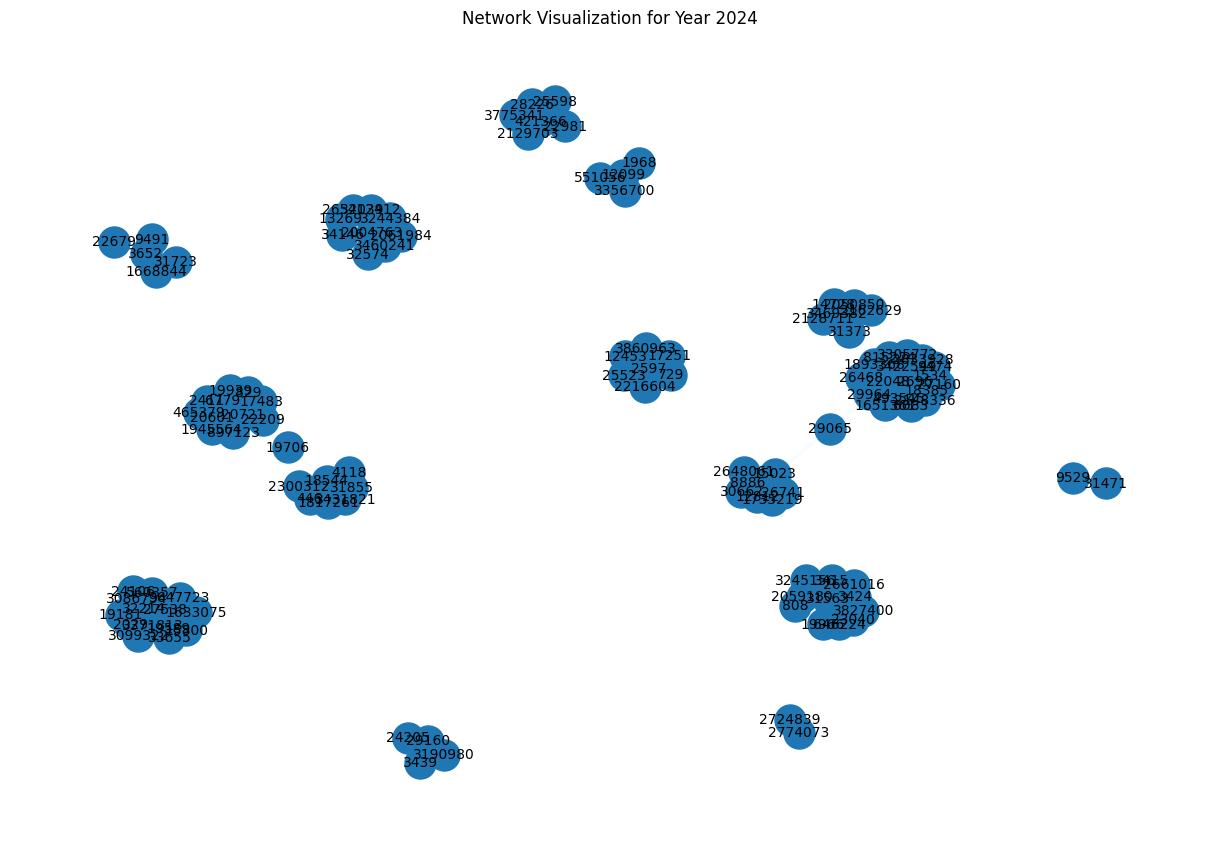

In [36]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Group the DataFrame by 'year'
results_list = []

for yr, df_year in filtered_2024.groupby('year'):
    # Ensure company IDs are strings
    df_year['company1_id'] = df_year['company1_id'].astype(str)
    df_year['company2_id'] = df_year['company2_id'].astype(str)
    
    # Get unique company IDs
    companies = sorted(pd.concat([df_year['company1_id'], df_year['company2_id']]).unique())
    
    # Create sorted pairs
    comp1 = df_year['company1_id'].values
    comp2 = df_year['company2_id'].values
    u = np.minimum(comp1, comp2)
    v = np.maximum(comp1, comp2)
    pairs = list(zip(u, v))
    
    # Compute edge weights
    edge_weights = pd.Series(pairs).value_counts().to_dict()
    
    # Create a NetworkX Graph
    G = nx.Graph()
    
    # Add weighted edges
    for (u, v), w in edge_weights.items():
        G.add_edge(u, v, weight=w)
    
    # Compute centrality measures
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G, distance='weight') 
    degree = nx.degree_centrality(G)  # Already normalized
    
    try:
        eigenvector = nx.eigenvector_centrality(G, weight='weight')  # Already normalized
    except Exception:
        eigenvector = {node: None for node in G.nodes()}
    
    # Create DataFrame
    df_metrics = pd.DataFrame({
        'company_linking': list(G.nodes()),
        'year': yr,
        'betweenness': [betweenness[node] for node in G.nodes()],
        'closeness': [closeness[node] for node in G.nodes()],
        'degree': [degree[node] for node in G.nodes()],  # Already normalized
        'eigenvector': [eigenvector[node] for node in G.nodes()],  # Already normalized
    })
    
    # Normalize only betweenness and closeness centrality
    scaler = MinMaxScaler()
    df_metrics[['betweenness', 'closeness']] = scaler.fit_transform(df_metrics[['betweenness', 'closeness']])
    
    results_list.append(df_metrics)

# Combine results into a single DataFrame
metrics_df = pd.concat(results_list, ignore_index=True)
print(metrics_df)

# Visualize the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
plt.title(f'Network Visualization for Year {yr}')
plt.show()


In [39]:
metrics_df.sort_values(by='degree', ascending=False)

,company_linking,year,betweenness,closeness,degree,eigenvector
25,22048,2024,1.00,1.00,0.16,0.69
2,27538,2024,0.20,0.68,0.12,0.00
101,20721,2024,0.32,0.53,0.10,0.00
4,31563,2024,0.11,0.51,0.09,0.00
34,2004763,2024,0.07,0.39,0.07,0.00
...,...,...,...,...,...,...
38,3460241,2024,0.00,0.18,0.01,0.00
37,3412412,2024,0.00,0.18,0.01,0.00
36,2652039,2024,0.00,0.18,0.01,0.00
35,2061984,2024,0.00,0.18,0.01,0.00


Summary Statistics:
       betweenness  closeness  degree  eigenvector
count       114.00     114.00  114.00       114.00
mean          0.03       0.32    0.02         0.04
std           0.12       0.20    0.02         0.09
min           0.00       0.00    0.01         0.00
25%           0.00       0.18    0.01         0.00
50%           0.00       0.32    0.01         0.00
75%           0.00       0.46    0.01         0.01
max           1.00       1.00    0.16         0.69


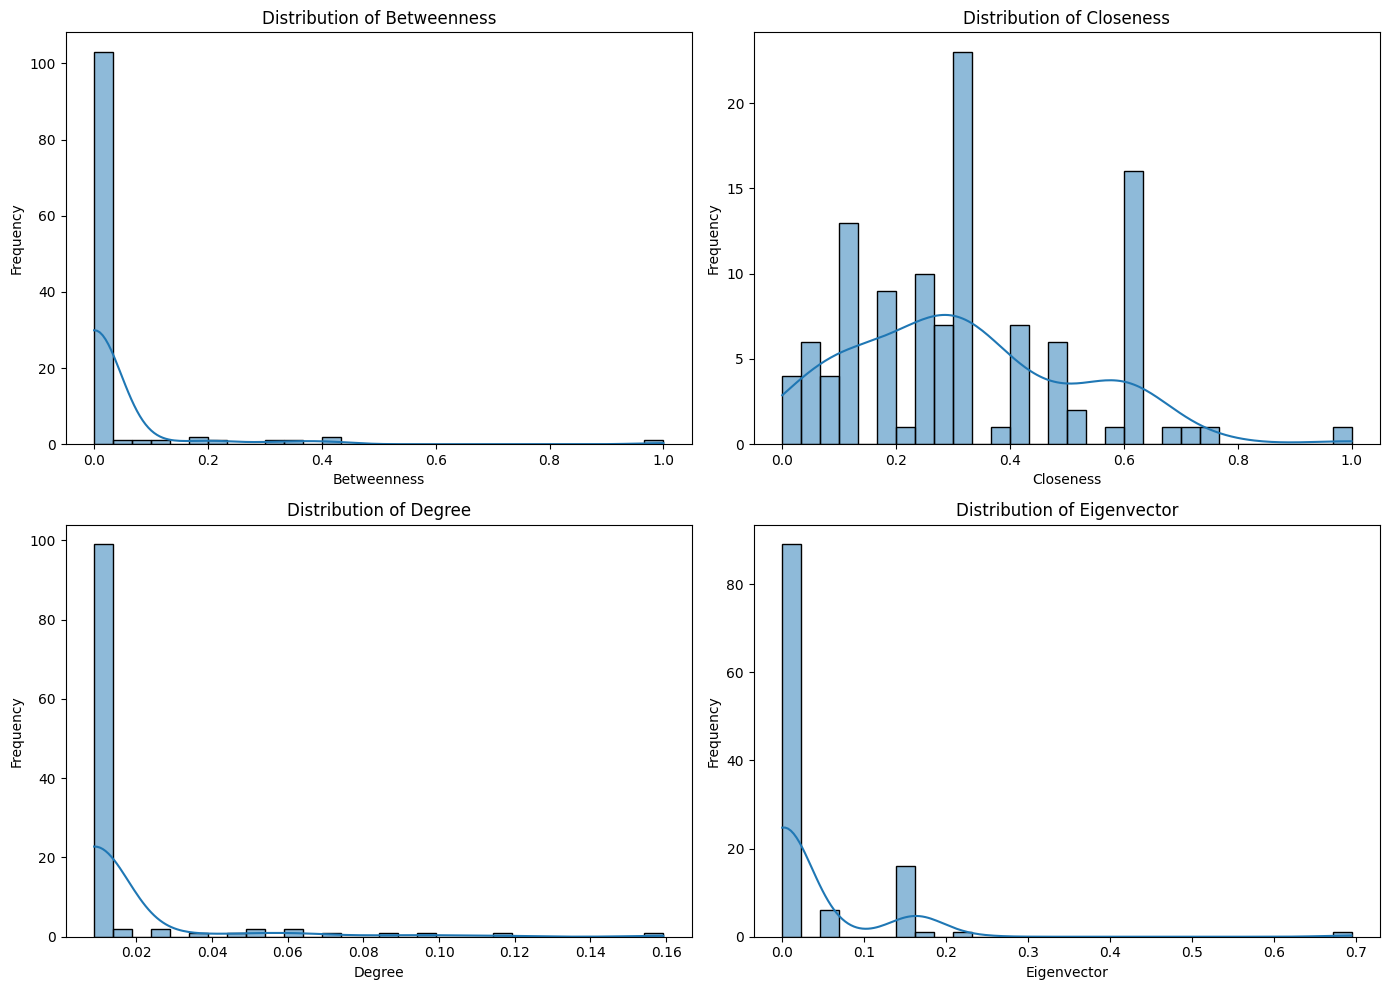

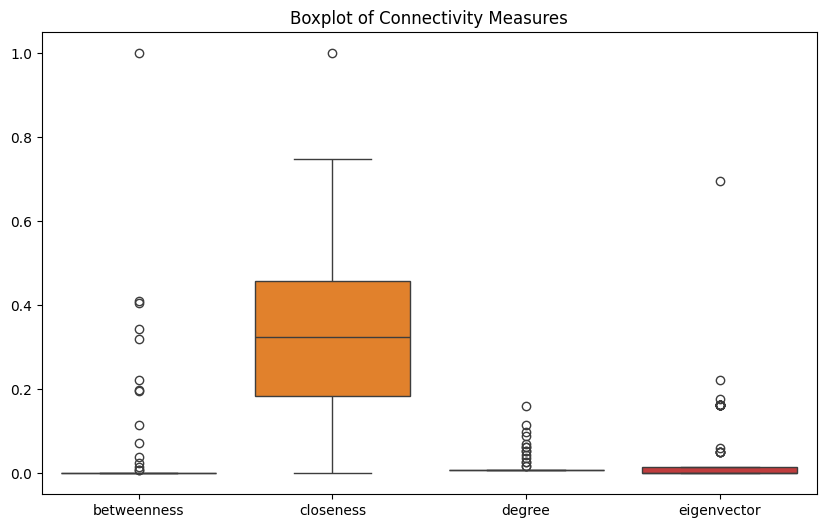

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', '{:,.2f}'.format)

# Display summary statistics for the connectivity measures
print("Summary Statistics:")
print(metrics_df[['betweenness', 'closeness', 'degree', 'eigenvector']].describe())

# Plot histograms with KDE for each connectivity measure
plt.figure(figsize=(14, 10))
centrality_measures = ['betweenness', 'closeness', 'degree', 'eigenvector']

for i, col in enumerate(centrality_measures, 1):
    plt.subplot(2, 2, i)
    sns.histplot(metrics_df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot a boxplot to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics_df[centrality_measures])
plt.title("Boxplot of Connectivity Measures")
plt.show()